In [1]:
from optical_flax.dsp import simple_dsp, mimo_dsp
from optical_flax.fiber_system import get_data
import matplotlib.pyplot as plt
import optical_flax.base as base
import optax
from gdbp import gdbp_base as gb, data as gdat, aux
import pickle



## real data
data_train = gdat.load(1, 0, 4, 2)[0]
data_test = gdat.load(2, 0, 4, 2)[0]

path = f'data/test_data/dataset_ch{7}_dz5_N4e5'
data_sml = get_data(path)

FSTimeoutError: 

# Experiment 1: mimo_dsp  + simulation data Ch = 7

           BER       QSq        SNR
dim0   0.02262  6.031087  12.669029
dim1   0.02306  5.995781  12.664515
total  0.02284  6.013380  12.666775


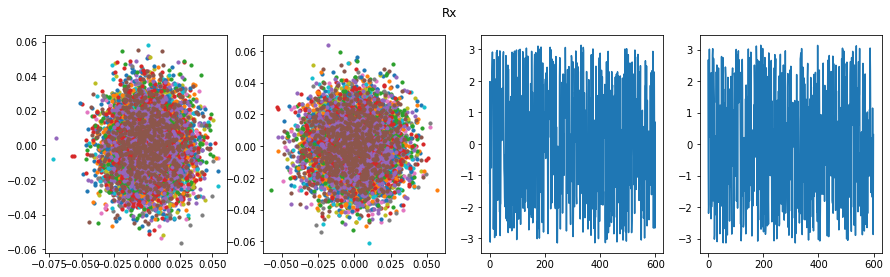

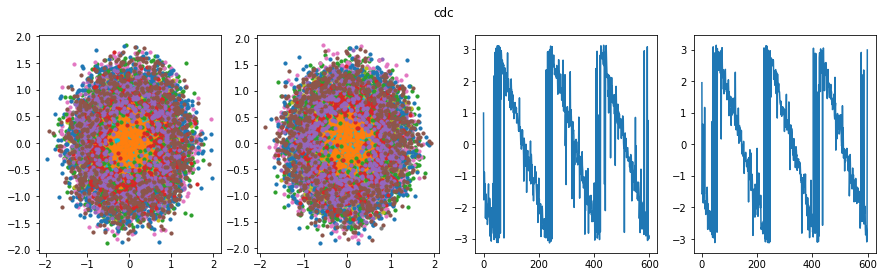

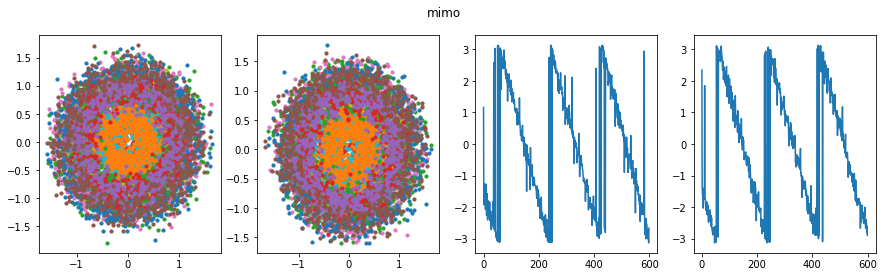

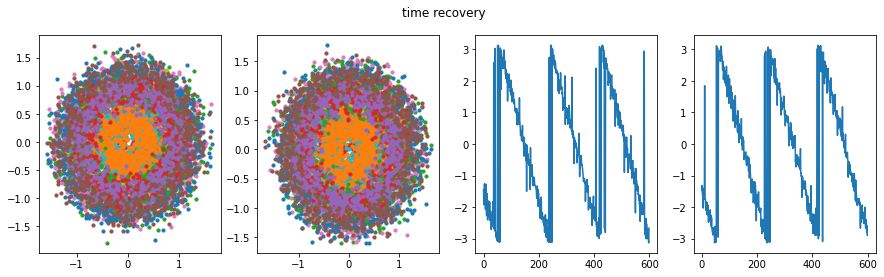

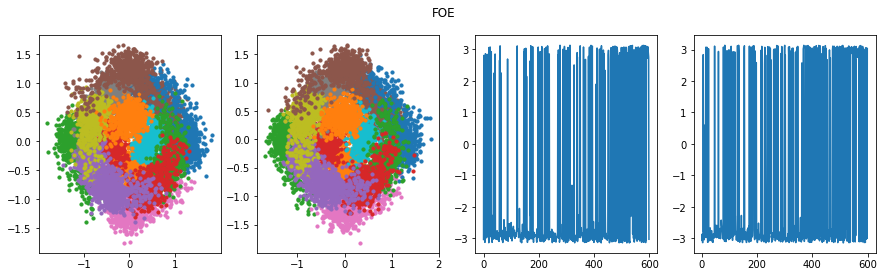

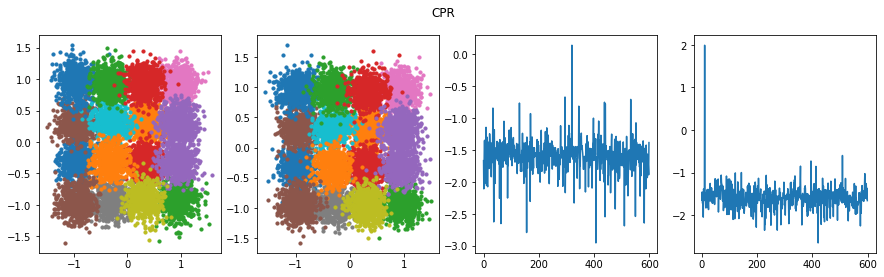

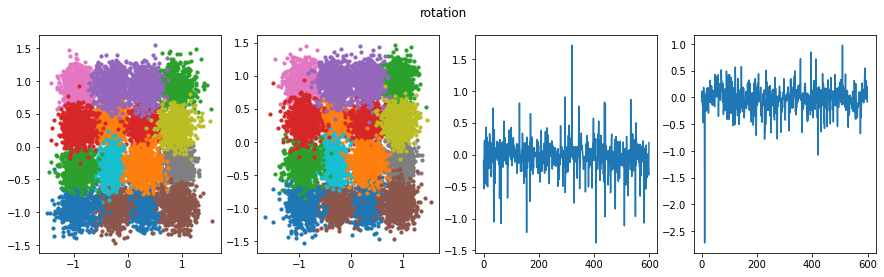

In [6]:
## mimo_dsp  + sml_data
data = data_sml
sig_list, name, metric = mimo_dsp(data)
print(metric)
base.show_fig(sig_list, data.x, name)

# Experiment 2: mimo_dsp  + real data Ch = 7

            BER       QSq        SNR
dim0   0.007062  7.797905  14.514248
dim1   0.010843  7.218709  13.890889
total  0.008953  7.486082  14.191391


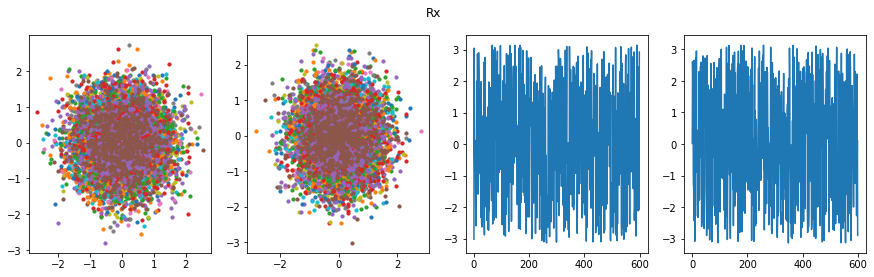

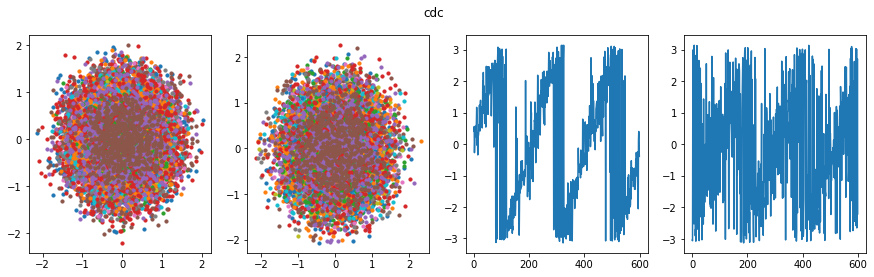

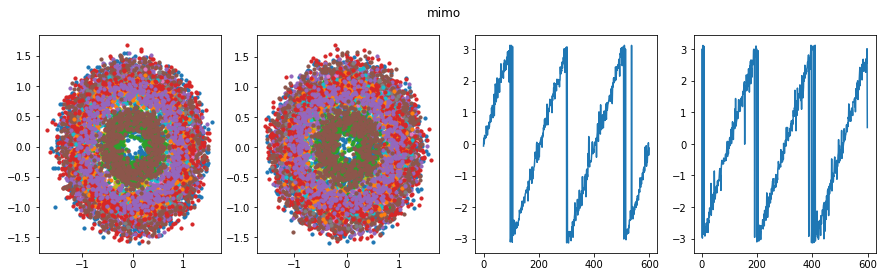

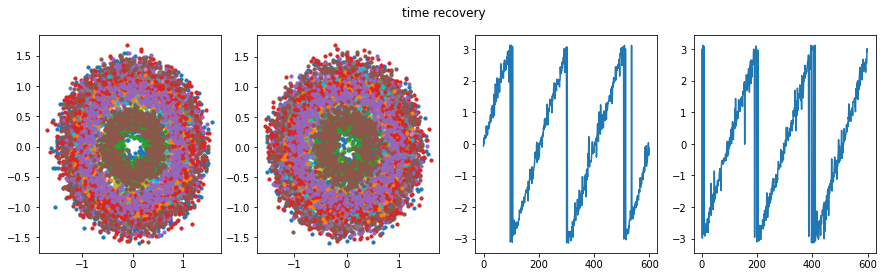

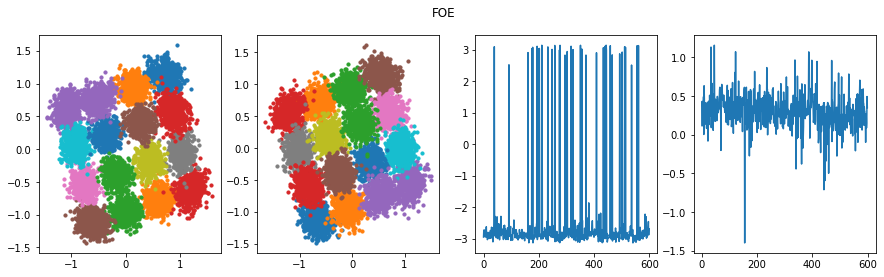

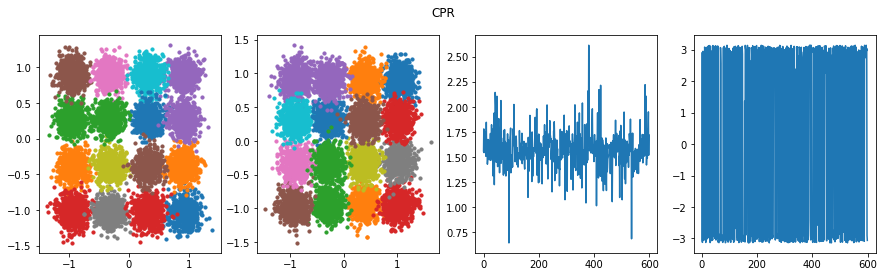

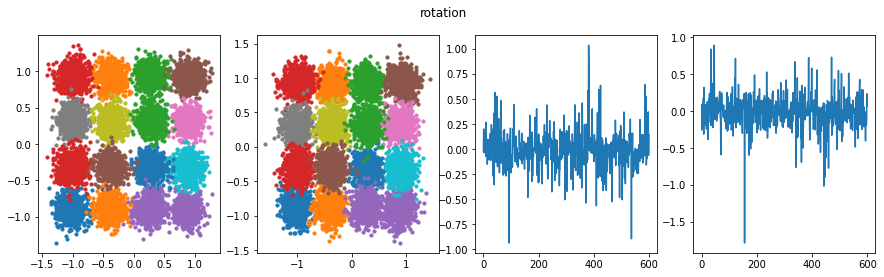

In [4]:
## mimo_dsp  + sml_data
data = data_test
sig_list, name, metric = mimo_dsp(data)
print(metric)
base.show_fig(sig_list, data.x, name)

# Experiment 3: train NN + real data  Ch=7

In [16]:
## Training FDBP Model on a signal 
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [1e-4, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)

## define model
batch_size = 500
sparams_flatkeys = []  # [('FDBP',),('RConv',)] static parameters
model_train = base.model_init(data_train, sparams_flatkeys=sparams_flatkeys, mode='train')  
model_test = base.model_init(data_test, sparams_flatkeys=sparams_flatkeys, mode='test')  

# train model
gen = base.train(model_train, data_train, batch_size=500, n_iter=2000, tx=tx)
loss0, Train0 = base.run_result(gen)

# test model
metric,sig_list = base.test(model_test, Train0[-1].params, data_test)

# saving result
with open('sml_data/TrainData','wb') as file:
    pickle.dump((loss0, Train0, sig_list, metric), file)

            BER       QSq        SNR
dim0   0.001985  9.189290  16.036516
dim1   0.004273  8.398022  15.160004
total  0.003129  8.735675  15.576189


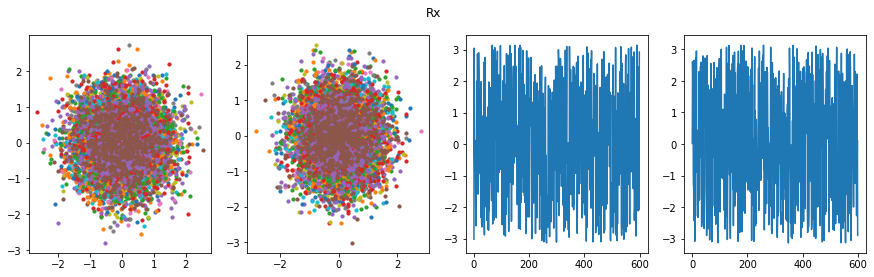

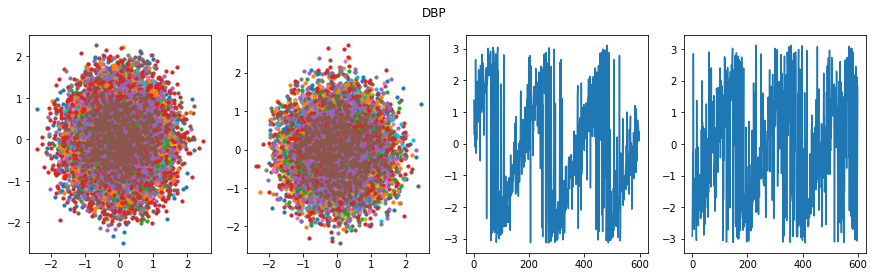

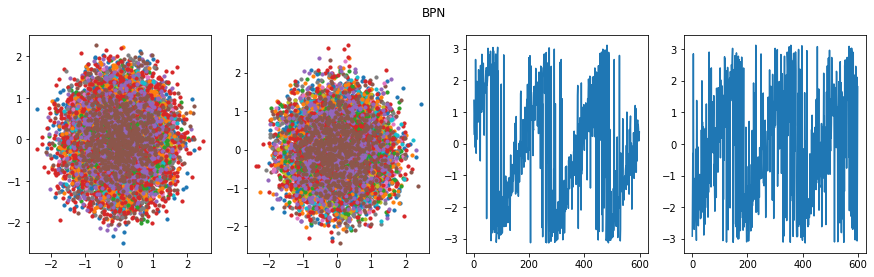

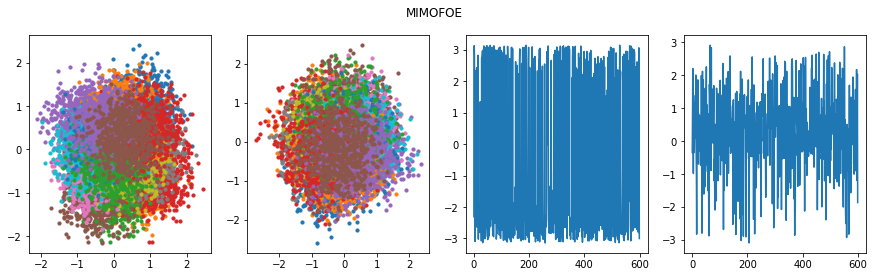

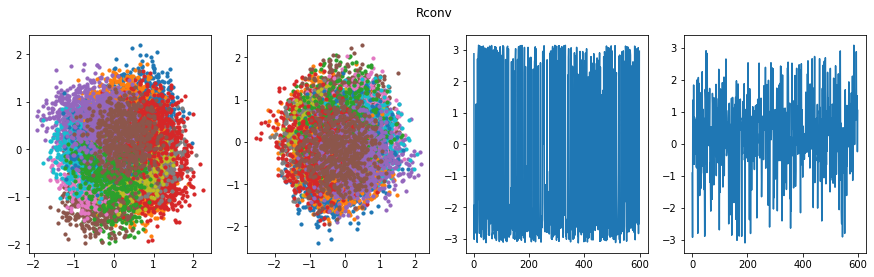

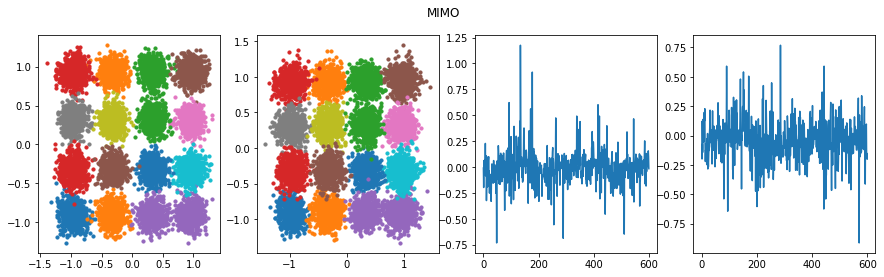

In [17]:
with open('sml_data/TrainData','rb') as file:
    (loss0, Train0, sig_list, metric) = pickle.load(file)
print(metric)
base.show_fig(sig_list, data_test.x, ['Rx','DBP','BPN','MIMOFOE','Rconv','MIMO'])

/Users/xinyu/opt/anaconda3/envs/commplax/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0


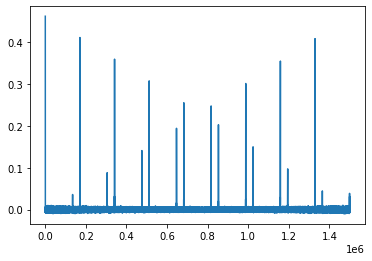

In [44]:
## test time recovery:  real data x 有一定的规律（周期性）
from optical_flax.utils import auto_rho
import numpy as np
num = 2
pol = 0
x = np.abs(data_test.x[:,pol])[sig_list[num].t.start//sig_list[num].t.sps :len(data_test.x) + sig_list[num].t.stop//sig_list[num].t.sps]
y = np.abs(sig_list[num].val[::sig_list[num].t.sps,pol])
plt.plot(auto_rho(x, y))
print(np.argmax(auto_rho(x,y).real))

# Experiment 4: Train NN + simulation data  Ch=7

In [12]:
## Training FDBP Model on a signal 
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [1e-4, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)

## define model
batch_size = 500
sparams_flatkeys = [] # [('DBP',),('RConv',)] static parameters
model_train = base.model_init(data_sml, sparams_flatkeys=sparams_flatkeys, mode='train')  
model_test = base.model_init(data_sml, sparams_flatkeys=sparams_flatkeys, mode='test')  

# train model
gen = base.train(model_train, data_sml, batch_size=500, n_iter=2000, tx=tx)
loss0, Train0 = base.run_result(gen)

# test model
metric,sig_list = base.test(model_test, Train0[-1].params, data_sml, eval_range=(30000,-20000))

# saving result
with open('sml_data/TrainData_sml','wb') as file:
    pickle.dump((loss0, Train0, sig_list, metric), file)

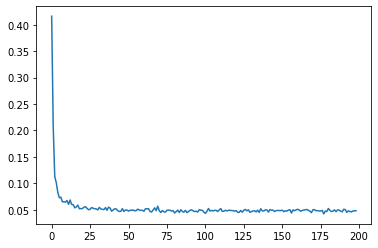

In [13]:
plt.plot(loss0)

In [14]:
print(metric)

            BER       QSq        SNR
dim0   0.017145  6.512986  13.095087
dim1   0.017074  6.519827  13.097216
total  0.017109  6.516404  13.096150


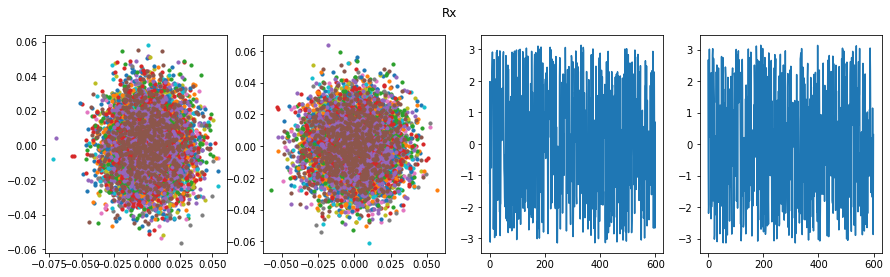

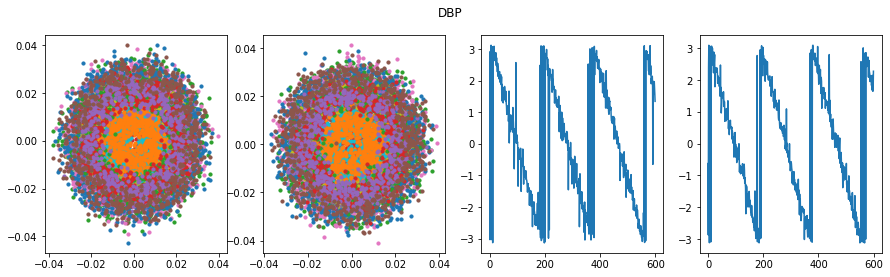

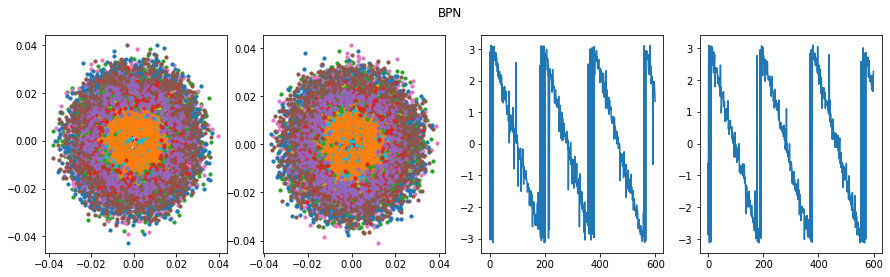

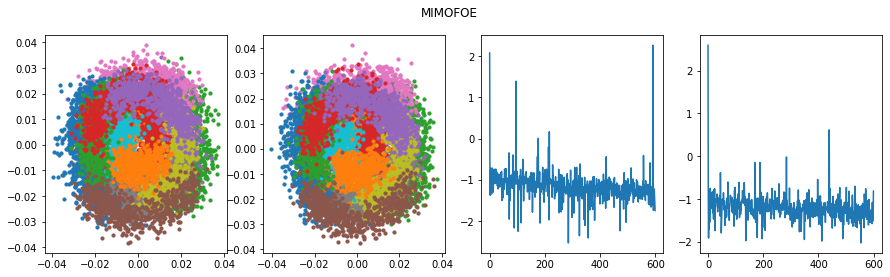

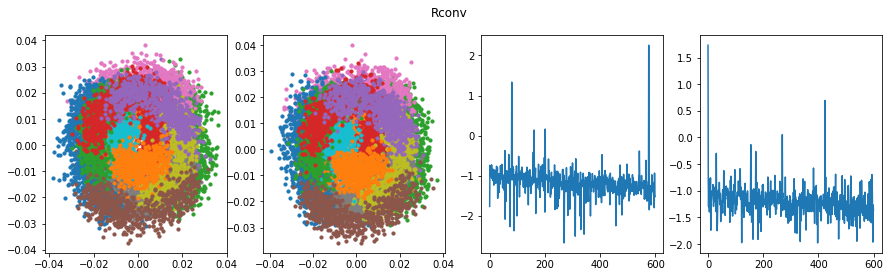

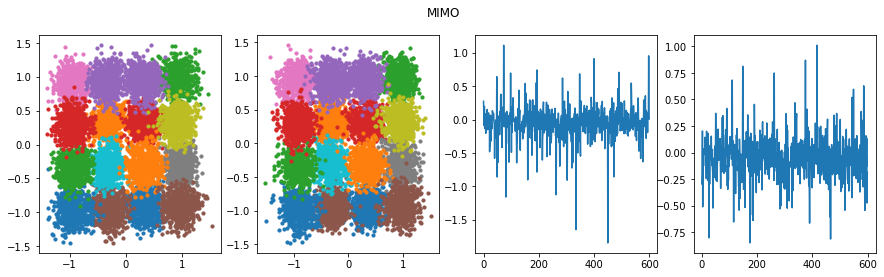

In [15]:
base.show_fig(sig_list, data_sml.x, ['Rx','DBP','BPN','MIMOFOE','Rconv','MIMO'])

# Experiment 5： Meta + real data

In [1]:
from optical_flax.dsp import simple_dsp, mimo_dsp
import matplotlib.pyplot as plt
import optical_flax.base as base
import optax
from collections import namedtuple
from gdbp import gdbp_base as gb, data as gdat, aux
import pickle
Input = namedtuple('DataInput', ['y', 'x', 'w0', 'a'])

## real data
data_train = gdat.load(1, 0, 4, 2)[0]
data_test = gdat.load(2, 0, 4, 2)[0]

with open(f'test_data/dataset_ch{7}_dz5_N4e5', 'rb') as file:
    b = pickle.load(file)
    data_sml = Input(b[0],b[1],-b[2],b[3])  # w0 计算有点错误（搞错了符号）

## Training Meta_DBP Model on a signal 
from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [1e-4, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)

## define model
batch_size = 500
sparams_flatkeys = []  # [('FDBP',),('RConv',)] static parameters
model = base.model_init(data_train,init_len = 1990, sparams_flatkeys=sparams_flatkeys,domain='frequency',GDBP=MetaSSFM, dtaps=1990, ntaps=1)  

# # train model
# gen = base.train(model, data_train, batch_size=500, n_iter=2000, tx=tx)
# loss1, Train1 = base.run_result(gen)

# # saving result
# with open('sml_data/MetaTrain_loss_state','wb') as file:
#     pickle.dump((loss1, Train1[-1]), file)

# load result
with open('sml_data/MetaTrain_loss_state','rb') as file:
    loss1, train_state = pickle.load(file)

# test model
model_test = base.model_init(data_test,init_len = 1990, sparams_flatkeys=sparams_flatkeys,domain='frequency',GDBP=MetaSSFM, dtaps=1990, ntaps=1, mode='test') 
metric, metric_list,res_list = base.test_meta(model_test, train_state.params, data_test)

In [2]:
metric

,BER,QSq,SNR
dim0,0.003485,inf,15.547456
dim1,0.005872,8.130259,14.834685
total,0.004679,8.389464,15.172995


In [32]:
from optical_flax.fiber_system import get_data
from optical_flax.utils import auto_rho
data = get_data('high_sps_data/dataset_ch7_dz1_N4e5',sps=2)

In [8]:
# Experiments 6: Meta + simulation data

In [4]:
from optical_flax.dsp import simple_dsp, mimo_dsp
import matplotlib.pyplot as plt
import optical_flax.base as base
import optax
from collections import namedtuple
from gdbp import gdbp_base as gb, data as gdat, aux
import pickle
Input = namedtuple('DataInput', ['y', 'x', 'w0', 'a'])

## real data
data_train = gdat.load(1, 0, 4, 2)[0]
data_test = gdat.load(2, 0, 4, 2)[0]

with open(f'test_data/dataset_ch{7}_dz5_N4e5', 'rb') as file:
    b = pickle.load(file)
    data_sml = Input(b[0],b[1],-b[2],b[3])  # w0 计算有点错误（搞错了符号）

## Training Meta_DBP Model on a signal 
from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [1e-4, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)

## define model
batch_size = 500
sparams_flatkeys = []  # [('FDBP',),('RConv',)] static parameters
model = base.model_init(data_sml,init_len = 1990, sparams_flatkeys=sparams_flatkeys,domain='frequency',GDBP=MetaSSFM, dtaps=1990, ntaps=1)  

# train model
gen = base.train(model, data_sml, batch_size=500, n_iter=2000, tx=tx)
loss1, Train1 = base.run_result(gen)

# saving result
with open('sml_data/MetaTrain_loss_state_smldata','wb') as file:
    pickle.dump((loss1, Train1[-1]), file)

# load result
with open('sml_data/MetaTrain_loss_state_smldata','rb') as file:
    loss1, train_state = pickle.load(file)

# test model
model_test = base.model_init(data_sml,init_len = 1990, sparams_flatkeys=sparams_flatkeys,domain='frequency',GDBP=MetaSSFM, dtaps=1990, ntaps=1, mode='test') 
metric, metric_list,res_list = base.test_meta(model_test, train_state.params, data_sml)

In [5]:
metric

,BER,QSq,SNR
dim0,0.018698,6.460021,13.000576
dim1,0.018630,6.465808,12.965980
total,0.018664,6.454060,12.980790


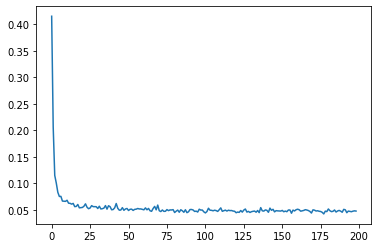

In [6]:
plt.plot(loss1)